<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
#загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import notebook

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import torch
import transformers
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
#сохраним датасет
try:
    toxic = pd.read_csv('/datasets/toxic_comments.csv')
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [4]:
#посмотрим на датасет
toxic.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
#взглянем на общую информацию о датасете
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В датасете два столбца и 159 571 строк. Пропусков нет. Посмотрим, есть ли в датасете дубликаты.

In [6]:
print('Количество пропусков в датасете:', toxic.duplicated().sum())

Количество пропусков в датасете: 0


И теперь посмотрим на соотношение негативных комментариев (признак 1) и позитивных комментариев (признак 0).

(-1.25, 1.25, -1.25, 1.25)

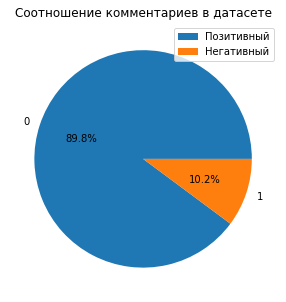

In [7]:
toxic['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Позитивный','Негативный'])
plt.title('Соотношение комментариев в датасете')
plt.axis('off')

Негативных комментариев всего 10,2 %, позитивных комментариев 89,8 %, в выборке большой дисбаланс.

Возьмем из выборки 5 000 случайных записей, чтобы не создавать эмбеддинги слишком долго и добавим негативные и позитивные комментарии в соотношении 50/50.

(-1.25, 1.25, -1.25, 1.25)

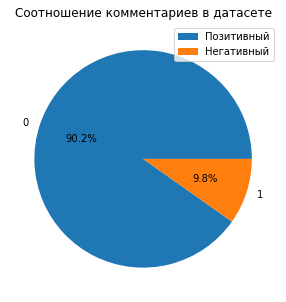

In [8]:
batch_toxic = toxic.sample(5000, random_state=12345).reset_index(drop=True)

#проверим на соотношение позитивных и негативных комментариев
batch_toxic['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Позитивный','Негативный'])
plt.title('Соотношение комментариев в датасете')
plt.axis('off')

Инициализируем токенизатор как объект класса BertTokenizer().

In [9]:
#возьмем уже обученную модель для выявления токсичных комментариев
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = batch_toxic['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

#инициализируем саму модель класса BertModel
model = AutoModel.from_pretrained('unitary/toxic-bert')

(5000, 512)


Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
%%time

#эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим
batch_size = 200

# сделаем пустой список для хранения эмбеддингов
embeddings = []


#cделаем цикл по батчам. Отображать прогресс будет функция notebook
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        # преобразуем данные в формат тензоров
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            #чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # преобразуем элементы методом numpy() к типу numpy.array
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: total: 4h 37min 40s
Wall time: 47min 22s


In [11]:
#cоберём все эмбеддинги в матрицу признаков
features = np.concatenate(embeddings) 
#и загрузим целевой признак
target = batch_toxic['toxic']

In [12]:
#подготовим обучающую, валидационную и тестовую выборки в соотношении 3:1:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print('Размер обучающей выборки:', len(target_train))
print('Размер тестовой выборки:', len(target_test))
print('Размер валидационной выборки:', len(target_valid))

Размер обучающей выборки: 3000
Размер тестовой выборки: 1000
Размер валидационной выборки: 1000


Эмбеддинги готовы, теперь обучим на них модели.

## Обучение

Обучим 4 модели: логистическую регрессию, случайный лес, Catboost и LightGBM.

In [42]:
%%time

#логистическая регрессия
logistic_model = LogisticRegression(random_state=12345, solver='saga')
logistic_model.fit(features_train, target_train)

print('F1 логистической регрессии:', cross_val_score(
    logistic_model, features_valid, target_valid, cv=5, scoring='f1').mean())

F1 логистической регрессии: 0.9525318309141838
CPU times: total: 8.66 s
Wall time: 4.68 s


In [43]:
%%time

#случайный лес

forest_model = RandomForestClassifier(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 20, 2)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='f1', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('F1 случайного леса составляет:',  cross_val_score(
    forest_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры случайного леса: {'max_depth': 12, 'n_estimators': 40}
F1 случайного леса составляет: 0.9349524658348187
CPU times: total: 4.59 s
Wall time: 29.3 s


In [44]:
%%time

#Catboost

cat_model = CatBoostClassifier(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.05, 0.1], #скорость обучения
              'depth':[5, 7]} #depth - глубина дерева
cat_grid = GridSearchCV(cat_model, cat_params, cv=3, scoring='f1', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print('Лучшие параметры Catboost:', cat_grid.best_params_)
print('F1 Catboost составляет:', cross_val_score(
    cat_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры Catboost: {'depth': 7, 'learning_rate': 0.05}
F1 Catboost составляет: 0.9525318309141838
CPU times: total: 4min 19s
Wall time: 5min 13s


In [45]:
%%time

#LightGBM

gbm_model = LGBMClassifier(random_state=12345)
gbm_params = {'n_estimators':[100, 150], #количество деревьев решений
              'num_leaves':[10, 15, 20]} #количество терминальных узлов (листьев) дерева
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='f1', n_jobs=-1)
gbm_grid.fit(features_train, target_train)

print('Лучшие параметры LightGBM:', gbm_grid.best_params_)
print('F1 LightGBM составляет:', cross_val_score(
    gbm_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Лучшие параметры LightGBM: {'n_estimators': 150, 'num_leaves': 15}
F1 LightGBM составляет: 0.9471536796536796
CPU times: total: 40 s
Wall time: 1min 31s


Все модели показали отличный результат f1 и самый минимальный результат получился у случайного леса равный 0.934. При этом чуть лучше всех оказался Catboost с результатом 0,952. Его и проверим на тестовой выборке.

Проверим адекватность работы нашей модели в сравнении с константной моделью.

In [46]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(features_train, target_train)
dummy_clf_pred = dummy_clf.predict(features_train)
print('Accuracy:', dummy_clf.score(dummy_clf_pred, target_train))
print('F1 Dummy:', cross_val_score(dummy_clf, features_valid, target_valid, cv=5, scoring='f1').mean())

Accuracy: 0.894
F1 Dummy: 0.0


F1 Dummy модели составляет 0.0, а accuracy составил 0.894, что логично, т.к. именно такое соотношение нулей и единиц в датасете.

In [47]:
data={'Модель': ['Linear Regression', 'RandomForest', 'Catboost', 'LightGBM', 'Dummy Model'],
      'F1:': [0.952, 0.934, 0.952, 0.947, 0.0]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,F1:
0,Linear Regression,0.952
1,RandomForest,0.934
2,Catboost,0.952
3,LightGBM,0.947
4,Dummy Model,0.000


Проверим Catboost с лучшими параметрами на тестовой выборке.

In [48]:
model = CatBoostClassifier(iterations=100, verbose=False,
                           random_state=12345, learning_rate=0.05, depth=7)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('F1 Catboost на тестовой выборке составляет:',
     cross_val_score(model, features_test, target_test, cv=5, scoring='f1').mean())

F1 Catboost на тестовой выборке составляет: 0.9646054171054171


Получили отличный результат f1, равный 0.964, что даже выше, чем на валидационной выборке.

## Выводы

1. Для подготовки текста была использована предобученная нейросеть BERT.
2. Из всего датасета для создания эмбеддингов была взята выборка из 5000 случайных записей.
3. Для обучения были выбраны 4 модели: логистическая регрессия, случайный лес, Catboost и LightGBM.
4. Все модели показали отличный результат f1, но чуть более лучший результат показала модель Catboost и на обучающей выборке был получен f1 равный 0.964, причем этот результат превысил результат валидационной выборки.